In [40]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
%matplotlib inline

DATASET_PATH = "/home/carlos/Escritorio/Tesis/data/Ravdess/archive"
MODEL_PATH = "/home/carlos/Escritorio/Tesis/modelo"
os.makedirs(MODEL_PATH, exist_ok=True)

# Analysis

¿Archivo existe?: True


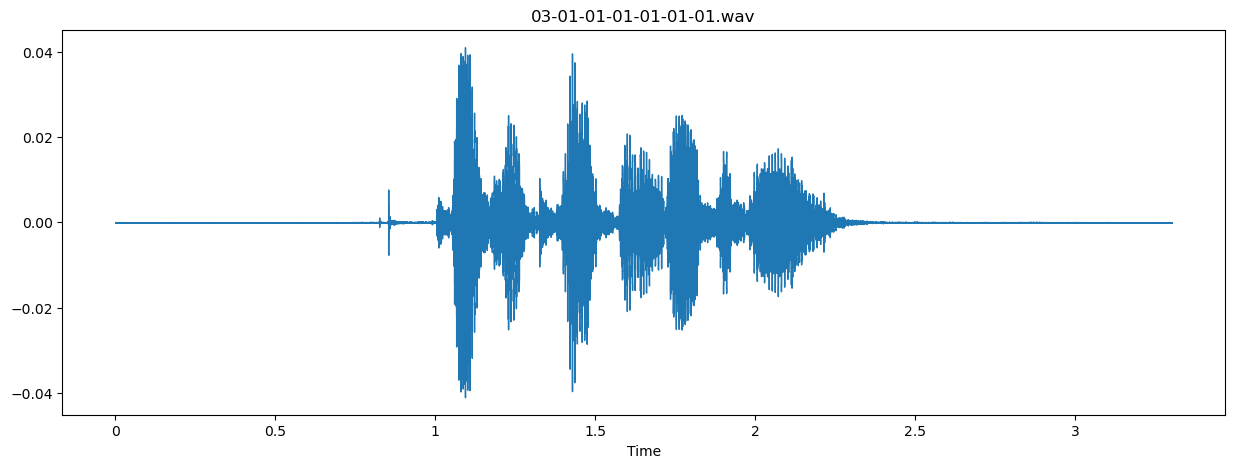

In [41]:
def plot_waveform(file_path):
    try:
        data, sr = librosa.load(file_path, sr=22050)
        plt.figure(figsize=(15,5))
        librosa.display.waveshow(data, sr=sr)
        plt.title(os.path.basename(file_path))
        plt.show()
    except Exception as e:
        print(f"Error: {str(e)}")

example_audio = os.path.join(DATASET_PATH, "Actor_01", "03-01-01-01-01-01-01.wav")
print("¿Archivo existe?:", os.path.exists(example_audio))
plot_waveform(example_audio)

In [42]:
features = []
labels = []

for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if not file.endswith(".wav"):
            continue
        try:
            file_path = os.path.join(root, file)
            X, sr = librosa.load(file_path, sr=22050, duration=3)

            mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40)
            delta = librosa.feature.delta(mfccs)
            combined = np.vstack([mfccs, delta]).T
            
            features.append(combined)
            labels.append(file.split("-")[2])
            
        except Exception as e:
            print(f"Error en {file}: {str(e)}")
            continue

print("\nVerificación:")
print(f"Muestras: {len(features)} | Pasos temporales: {len(features[0])} | Características: {len(features[0][0])}")
print("Distribución de clases:", pd.Series(labels).value_counts().sort_index())


Verificación:
Muestras: 2880 | Pasos temporales: 130 | Características: 80
Distribución de clases: 01    192
02    384
03    384
04    384
05    384
06    384
07    384
08    384
Name: count, dtype: int64


In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 130
X_padded = pad_sequences(
    features, 
    maxlen=max_length, 
    dtype="float32", 
    padding="post", 
    truncating="post"
)

y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, 
    y, 
    test_size=0.25, 
    stratify=y, 
    random_state=42
)

print("\nDatos finales:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")


Datos finales:
X_train: (2160, 130, 80)
X_test: (720, 130, 80)


# Decision Tree Classifier

In [45]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

dtree = DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)

dtree.fit(X_train_flat, y_train)
y_pred = dtree.predict(X_test_flat)

print("\nDecision Tree - Reporte:")
print(classification_report(y_test, y_pred, digits=3))


Decision Tree - Reporte:
              precision    recall  f1-score   support

          01      0.638     0.625     0.632        48
          02      0.767     0.823     0.794        96
          03      0.670     0.656     0.663        96
          04      0.716     0.604     0.655        96
          05      0.663     0.719     0.690        96
          06      0.663     0.656     0.660        96
          07      0.629     0.635     0.632        96
          08      0.596     0.615     0.605        96

    accuracy                          0.669       720
   macro avg      0.668     0.667     0.666       720
weighted avg      0.670     0.669     0.669       720



In [46]:
joblib.dump(dtree, os.path.join(MODEL_PATH, "decision_tree_40mfccs.joblib"))
print(f"Modelo guardado en: {os.path.join(MODEL_PATH, 'decision_tree_40mfccs.joblib')}")

Modelo guardado en: /home/carlos/Escritorio/Tesis/modelo/decision_tree_40mfccs.joblib


# Random Forest

In [47]:
rforest = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rforest.fit(X_train_flat, y_train)
y_pred = rforest.predict(X_test_flat)

print("\nRandom Forest - Reporte:")
print(classification_report(y_test, y_pred, digits=3))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s



Random Forest - Reporte:
              precision    recall  f1-score   support

          01      0.842     0.667     0.744        48
          02      0.738     1.000     0.850        96
          03      1.000     0.750     0.857        96
          04      0.907     0.812     0.857        96
          05      0.915     0.896     0.905        96
          06      0.978     0.917     0.946        96
          07      0.865     0.938     0.900        96
          08      0.830     0.917     0.871        96

    accuracy                          0.875       720
   macro avg      0.884     0.862     0.866       720
weighted avg      0.887     0.875     0.874       720



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [48]:
joblib.dump(rforest, os.path.join(MODEL_PATH, "random_forest_40mfccs.joblib"))
print(f"Modelo guardado en: {os.path.join(MODEL_PATH, 'random_forest_40mfccs.joblib')}")

Modelo guardado en: /home/carlos/Escritorio/Tesis/modelo/random_forest_40mfccs.joblib


# Natural network

In [49]:
x_traincnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
x_testcnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print("\nVerificación de dimensiones CNN:")
print("x_traincnn.shape:", x_traincnn.shape)
print("x_testcnn.shape:", x_testcnn.shape)


Verificación de dimensiones CNN:
x_traincnn.shape: (2160, 130, 80, 1)
x_testcnn.shape: (720, 130, 80, 1)


In [50]:
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)

print("\nEtiquetas codificadas:")
print("Clases originales:", le.classes_)
print("Ejemplo y_train_int:", y_train_int[:5])
print("Ejemplo y_test_int:", y_test_int[:5])


Etiquetas codificadas:
Clases originales: ['01' '02' '03' '04' '05' '06' '07' '08']
Ejemplo y_train_int: [0 1 4 6 1]
Ejemplo y_test_int: [7 2 6 5 3]


In [51]:
model = Sequential()

model.add(Conv1D(256, 5, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

model.add(Conv1D(128, 3, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation="softmax"))

opt = Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 256)          102656    
                                                                 
 batch_normalization (BatchN  (None, 126, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 63, 256)          0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 256)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 61, 128)           98432     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 128)         

In [52]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [53]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5)
]

cnnhistory = model.fit(
    x_traincnn,
    y_train_int,
    batch_size=32,
    epochs=100,
    validation_data=(x_testcnn, y_test_int),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
68/68 [==============================] - 11s 113ms/step - loss: 3.9223 - accuracy: 0.1889 - val_loss: 3.6978 - val_accuracy: 0.1889 - lr: 1.0000e-04
Epoch 2/100
68/68 [==============================] - 7s 108ms/step - loss: 3.2477 - accuracy: 0.2611 - val_loss: 3.1047 - val_accuracy: 0.2764 - lr: 1.0000e-04
Epoch 3/100
68/68 [==============================] - 7s 109ms/step - loss: 3.1257 - accuracy: 0.2810 - val_loss: 2.9467 - val_accuracy: 0.3375 - lr: 1.0000e-04
Epoch 4/100
68/68 [==============================] - 7s 110ms/step - loss: 3.0189 - accuracy: 0.2972 - val_loss: 2.8286 - val_accuracy: 0.4028 - lr: 1.0000e-04
Epoch 5/100
68/68 [==============================] - 7s 110ms/step - loss: 2.9609 - accuracy: 0.3134 - val_loss: 2.7347 - val_accuracy: 0.4153 - lr: 1.0000e-04
Epoch 6/100
68/68 [==============================] - 7s 110ms/step - loss: 2.8992 - accuracy: 0.3389 - val_loss: 2.6415 - val_accuracy: 0.4556 - lr: 1.0000e-04
Epoch 7/100
68/68 [====================

In [54]:
import os
from tensorflow.keras.models import save_model

model_path = os.path.join(MODEL_PATH, "ravdess_cnn_model.h5")

if 'model' in globals():
    try:
        save_model(model, model_path)
        if os.path.isfile(model_path):
            print(f" Modelo CNN guardado en: {model_path}")
            print(f"   Tamaño: {os.path.getsize(model_path)/1024/1024:.2f} MB")
        else:
            print(" Error: El archivo no se creó correctamente")
    except Exception as e:
        print(f"Error al guardar el modelo: {str(e)}")
else:
    print("Error: El modelo no está definido en el entorno")

 Modelo CNN guardado en: /home/carlos/Escritorio/Tesis/modelo/ravdess_cnn_model.h5
   Tamaño: 5.19 MB


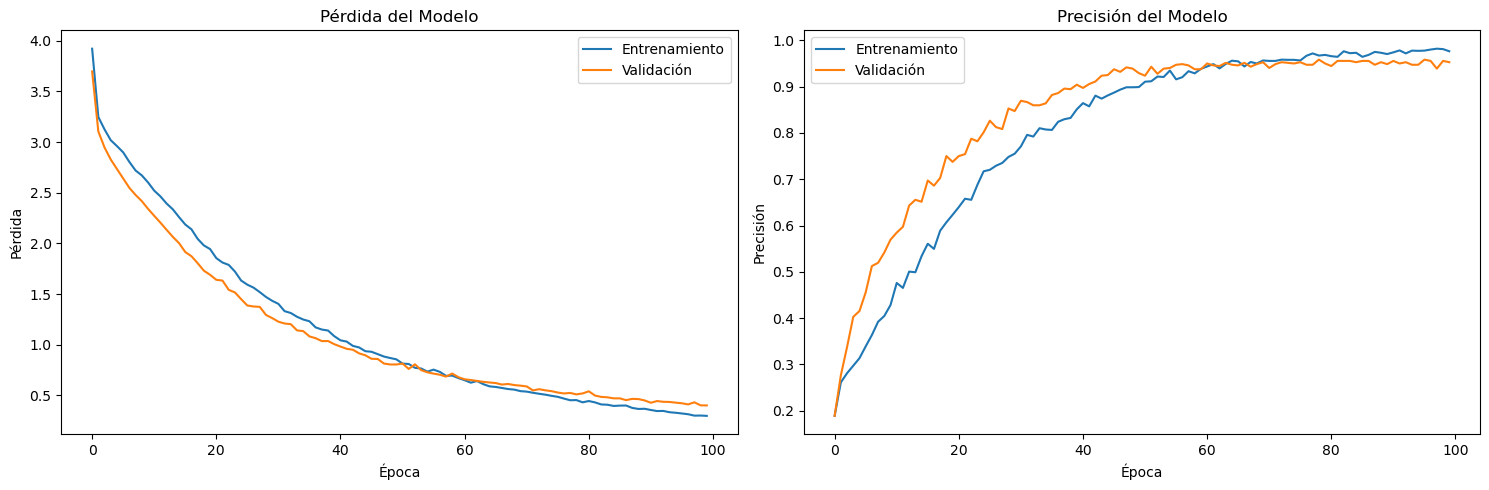

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(cnnhistory.history['loss'], label='Entrenamiento')
axs[0].plot(cnnhistory.history['val_loss'], label='Validación')
axs[0].set_title('Pérdida del Modelo')
axs[0].set_ylabel('Pérdida')
axs[0].set_xlabel('Época')
axs[0].legend()

axs[1].plot(cnnhistory.history['accuracy'], label='Entrenamiento')
axs[1].plot(cnnhistory.history['val_accuracy'], label='Validación')
axs[1].set_title('Precisión del Modelo')
axs[1].set_ylabel('Precisión')
axs[1].set_xlabel('Época')
axs[1].legend()

plt.tight_layout()
plt.show()

# Save the model

In [56]:
model_name = 'Emotion_Voice_Detection_Model_CNN.h5'
save_dir = MODEL_PATH

os.makedirs(save_dir, exist_ok=True)

if 'model' in globals():
    model_path = os.path.join(save_dir, model_name)
    
    try:
        model.save(model_path)
        print(f'\n Modelo CNN guardado en: {model_path}')
        print(f'Tamaño: {os.path.getsize(model_path)/1024/1024:.2f} MB')
    except Exception as e:
        print(f' Error al guardar: {str(e)}')
else:
    print("Error: El modelo no está definido")


 Modelo CNN guardado en: /home/carlos/Escritorio/Tesis/modelo/Emotion_Voice_Detection_Model_CNN.h5
Tamaño: 5.19 MB


# Reloading the model to test it 

In [57]:
from tensorflow.keras.models import load_model

model_path = os.path.join(MODEL_PATH, 'Emotion_Voice_Detection_Model_CNN.h5')

if os.path.isfile(model_path):
    try:
        loaded_model = load_model(model_path)
        print("\n" + "="*50)
        print(f"Modelo cargado de: {model_path}")
        print("Arquitectura:")
        loaded_model.summary()
        print("="*50)
    except Exception as e:
        print(f"Error al cargar: {str(e)}")
else:
    print(f" Archivo no encontrado: {model_path}")



Modelo cargado de: /home/carlos/Escritorio/Tesis/modelo/Emotion_Voice_Detection_Model_CNN.h5
Arquitectura:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 256)          102656    
                                                                 
 batch_normalization (BatchN  (None, 126, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 63, 256)          0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 256)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 61, 128)           98432     
            

# Checking the accuracy of the loaded model

In [58]:
if 'loaded_model' in globals() and 'x_testcnn' in globals() and 'y_test_int' in globals():
    loss, accuracy = loaded_model.evaluate(
        x_testcnn,
        y_test_int,
        verbose=1
    )
    
    print("\n" + "="*55)
    print("Evaluación del Modelo Cargado:")
    print(f"- Pérdida: {loss:.4f}")
    print(f"- Precisión: {accuracy * 100:.2f}%")
    print("="*55)
    
    best_val_acc = max(cnnhistory.history['val_accuracy'])
    print(f"\nMejor precisión en validación durante entrenamiento: {best_val_acc*100:.2f}%")
else:
    print("Error: Modelo o datos de prueba no disponibles")

23/23 [==============================] - 1s 19ms/step - loss: 0.4013 - accuracy: 0.9528

Evaluación del Modelo Cargado:
- Pérdida: 0.4013
- Precisión: 95.28%

Mejor precisión en validación durante entrenamiento: 95.83%
